In [1]:
# load libraries
from pl_temp_fit import PLPYMCModel, ELPYMCModel
import arviz as az
import pymc as pm
print(f"Running on PyMC v{pm.__version__}")
import numpy as np
import os
import matplotlib.pyplot as plt
from pl_temp_fit import ELPYMCModel, PLPYMCModel



Running on PyMC v5.10.3


In [162]:
#initialise parameters for the model
number_free_parameters , sigma, Temp_std_err, hws_std_err, relative_intensity_std_error = 3, 0.001, 2, 0.00, 0.05
temperature_list = np.array([300.0, 250.0, 200.0, 150.0, 80.0])
hws = np.arange(0.8, 2, 0.02)
num_samples = 2000
num_tune = 1000

model_config = {
            "number_free_parameters": number_free_parameters,
            "sigma": sigma,
            "Temp_std_err": Temp_std_err,
            "hws_std_err": hws_std_err,
            "relative_intensity_std_error": relative_intensity_std_error,
        }
X = {'temperature_list':temperature_list, 'hws':hws}
# generate the data
save_folder = (
    "test_results_EL_09_01/num_samples="
    + str(num_samples)
    + " num_tune=" + str(num_tune)
    + " sigma=" + str(sigma)
    + " temperature_list=" + str(len(temperature_list))
    + " number_free_parameters=" + str(number_free_parameters)
    + " Temp_std_err="+str(Temp_std_err)
    + " hws_std_err="+str(hws_std_err)
    + " relative_intensity_std_error="+str(relative_intensity_std_error)
)
os.makedirs(save_folder, exist_ok=True)

In [163]:
#generate data
def generate_data(temperature_list, hws,sigma,Temp_std_err,hws_std_err,relative_intensity_std_error,number_free_parameters,true_parameters = None,
                  **kwargs):
    if true_parameters is None:
        E_true = 1.4
        k_EXCT_true, fosc_CT_true = 9, -2.3
        LI_true = 0.1
        L0_true = 0.1
        H0_true = 0.15
        true_parameters = [E_true, k_EXCT_true, fosc_CT_true, LI_true, L0_true, H0_true]

    else:
        E_true, k_EXCT_true, fosc_CT_true, LI_true, L0_true, H0_true = true_parameters
    # error in the temperature of the sample
    temperature_list = temperature_list+np.random.normal(0, Temp_std_err, len(temperature_list))
    # error in the detection wavelength
    hws = hws+np.random.normal(0, hws_std_err, len(hws))
    truemodel_El = ELPYMCModel.el_trial(
        true_parameters,
        temperature_list, hws
    ) 
    # relative intensity error
    relative_intensity_model = np.max(truemodel_El, axis=0)/max(truemodel_El.reshape(-1, 1))
    relative_intensity_model_error = relative_intensity_model + np.random.normal(0, relative_intensity_std_error, len(relative_intensity_model))
    relative_intensity_model_error= relative_intensity_model_error/np.max(relative_intensity_model_error)
    truemodel_El=truemodel_El * relative_intensity_model_error / relative_intensity_model
    relative_intensity_model = np.max(truemodel_El, axis=0)/max(truemodel_El.reshape(-1, 1))
    # uniform error accross the spectrum
    truemodel_El = truemodel_El+np.random.normal(0, sigma, size=(len(hws), len(temperature_list)))

    return truemodel_El, true_parameters
truemodel_pl, true_parameters = generate_data(temperature_list, hws, **model_config)


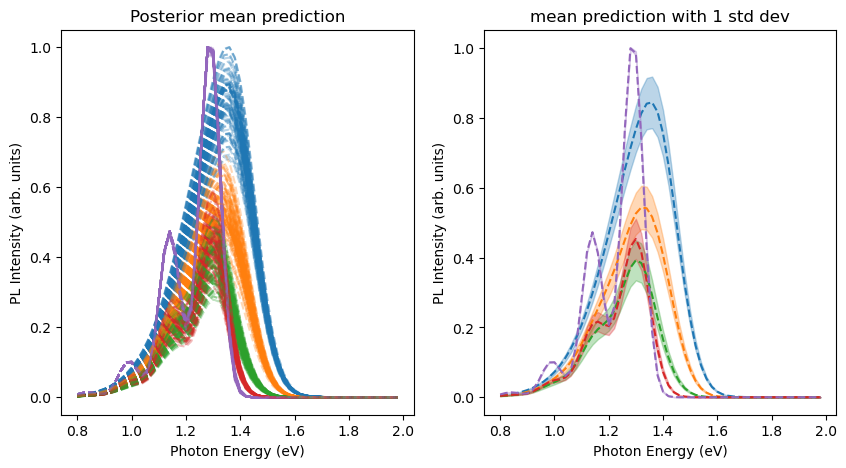

In [164]:
#plot the generated data
def plot_generated_data(truemodel_pl, temperature_list, hws, save_folder, model_config, savefig=True):
    fig, ax = plt.subplots(1,2, figsize=(10, 5))
    true_model_pl_list = []

    for x in range(100):
        truemodel_pl, true_parameters = generate_data(temperature_list, hws,**model_config)
        data_true_plot = truemodel_pl.reshape(len(hws), -1)
        data_true_plot = data_true_plot/max(data_true_plot.reshape(-1, 1))
        true_model_pl_list.append(data_true_plot.reshape(len(hws), len(temperature_list)))

        for i in range(len(temperature_list)):
            ax[0].plot(
                hws,
                data_true_plot[:, i],
                label="true" + str(temperature_list[i]) + " K",
                linestyle="--",
                color="C" + str(i),
                alpha=0.3,
            )
        ax[0].set_xlabel("Photon Energy (eV)")
        ax[0].set_ylabel("PL Intensity (arb. units)")
        ax[0].set_title("Posterior mean prediction")
    variance = np.var(np.array(true_model_pl_list), axis=0)
    mean_value_plot = np.mean(np.array(true_model_pl_list), axis=0)
    arg_max_variance = np.argmax(mean_value_plot, axis=0)

    for i in range(len(temperature_list)):
        
        ax[1].plot(
            hws,
            mean_value_plot[:, i],
            label="true" + str(temperature_list[i]) + " K",
            linestyle="--",
            color="C" + str(i),
        )
        ax[1].fill_between(
            hws,
            np.mean(np.array(true_model_pl_list), axis=0)[:, i]
            - np.sqrt(variance[:, i]),
            np.mean(np.array(true_model_pl_list), axis=0)[:, i]
            + np.sqrt(variance[:, i]),
            alpha=0.3,
            color="C" + str(i),
        )
        ax[1].set_xlabel("Photon Energy (eV)")
        ax[1].set_ylabel("PL Intensity (arb. units)")
        ax[1].set_title("mean prediction with 1 std dev")

    if savefig:
        fig.savefig(save_folder + "/generated_data.png")
    return mean_value_plot,variance,arg_max_variance
true_model_pl_list,variance,arg_max_variance = plot_generated_data(truemodel_pl, temperature_list, hws, save_folder, model_config, savefig=True)

(0.1, 1)

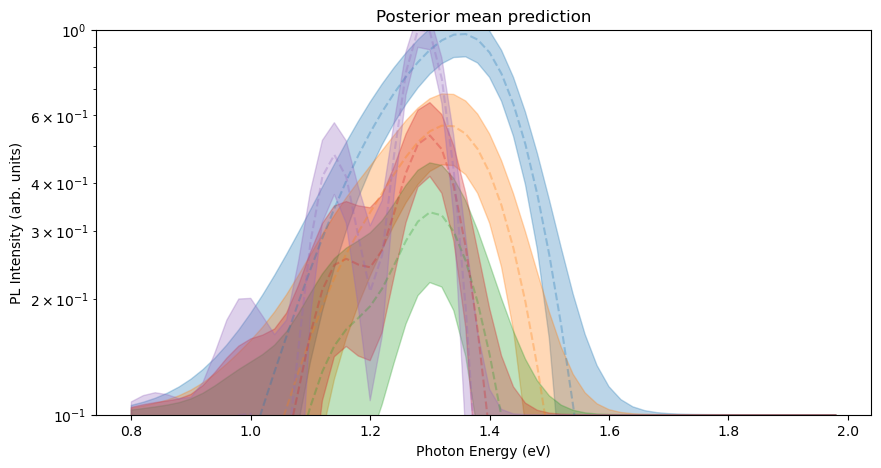

In [173]:
#transfer variance to new data
true_parameters=[1.4, 9, -2.3, 0.1, 0.1, 0.15]
mean_value_plot = np.mean(np.array(true_model_pl_list), axis=0)
truemodel_pl, true_parameters = generate_data(temperature_list, hws, **model_config, true_parameters=true_parameters)
truemodel_pl = truemodel_pl.reshape(len(hws), -1)
truemodel_pl = truemodel_pl/max(truemodel_pl.reshape(-1, 1))
variance_data = variance.copy()
argmax_data = np.argmax(truemodel_pl, axis=0)
for i in range(len(temperature_list)):
    variance_data[:, i] = np.roll(variance_data[:, i], argmax_data[i]-arg_max_variance[i])
variance_data = variance_data+0.01
fig, ax = plt.subplots(1,1, figsize=(10, 5))

for i in range(len(temperature_list)):
    ax.plot(
        hws,
        truemodel_pl[:, i],
        label="true" + str(temperature_list[i]) + " K",
        linestyle="--",
        color="C" + str(i),
        alpha=0.3,
    )
    ax.fill_between(
            hws,
            truemodel_pl[:, i]
            - np.sqrt(variance_data[:, i]),
            truemodel_pl[:, i]
            + np.sqrt(variance_data[:, i]),
            alpha=0.3,
            color="C" + str(i),
        )
ax.set_xlabel("Photon Energy (eV)")
ax.set_ylabel("PL Intensity (arb. units)")
ax.set_title("Posterior mean prediction")
ax.set_yscale('log')
ax.set_ylim([1e-1, 1])

{'number_free_parameters': 3, 'E': {'min': 1.0, 'max': 1.4}, 'k_EXCT': {'min': 8, 'max': 12}, 'fosc_CT': {'min': -4, 'max': 0}, 'LI': {'mu': 0.12, 'sigma': 0.01, 'lower': 0.05, 'upper': 0.15}, 'L0': {'mu': 0.12, 'sigma': 0.01, 'lower': 0.05, 'upper': 0.15}, 'H0': {'mu': 0.12, 'sigma': 0.01, 'lower': 0.12, 'upper': 0.18}, 'Temp_std_err': 2, 'hws_std_err': 0.0, 'relative_intensity_std_error': 0.05, 'sigma': 0.001}
{'draws': 10, 'tune': 5, 'chains': 3, 'step': 'pm.DEMetropolis()', 'return_inferencedata': True}
{'draws': 100, 'tune': 50, 'chains': 4, 'return_inferencedata': True, 'progressbar': True, 'random_seed': None}


Only 100 samples in chain.
Population sampling (4 chains)
DEMetropolis: [E, k_EXCT, fosc_CT]
Attempting to parallelize chains to all cores. You can turn this off with `pm.sample(cores=1)`.


/rds/general/user/ma11115/home/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:844: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
/rds/general/user/ma11115/home/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:844: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
/rds/general/user/ma11115/home/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:844: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
/rds/general/user/ma11115/home/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:844: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
Sampling 4 chains for 50 tune and 100 draw iterations (200 + 400 draws total) took 74 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.0

           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
E         1.304  0.025   1.273    1.322      0.008    0.006       8.0   
k_EXCT   10.820  0.365  10.178   11.214      0.114    0.083      10.0   
fosc_CT  -2.783  0.552  -3.415   -1.830      0.130    0.101      13.0   

         ess_tail  r_hat  
E            16.0   1.56  
k_EXCT       29.0   1.45  
fosc_CT      16.0   1.25  


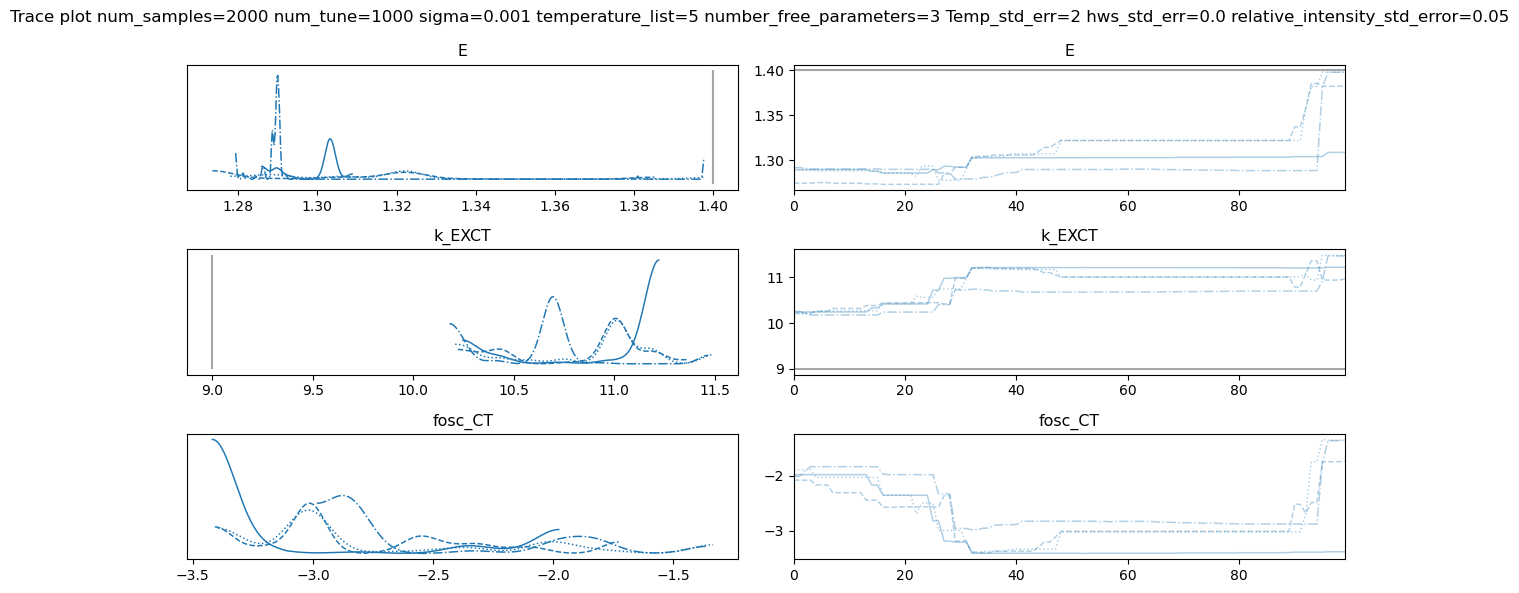

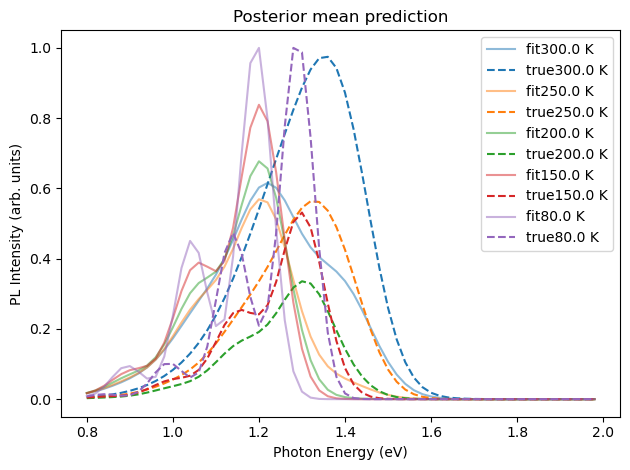

In [175]:
from pl_temp_fit import ELPYMCModel
import importlib
importlib.reload(ELPYMCModel)
## initialise the model and run the fit
model = ELPYMCModel.ELPYMCModel()
for key, value in model_config.items():
    model.model_config[key] = value
print(model.model_config)      
model.sampler_config['step'] = "pm.DEMetropolis()"#"[pm.DEMetropolis([self.E,self.LI,self.sigma_E]),pm.DEMetropolis([self.L0,self.H0])]"  
print(model.sampler_config)
#model.fit(X, truemodel_pl,sigma=variance_data, draws=num_samples, tune=num_tune, chains=4, step=model.sampler_config['step'] , return_inferencedata=True)
model.fit(X, truemodel_pl,sigma=variance_data, draws=100, tune=50, chains=4, step=model.sampler_config['step'] , return_inferencedata=True)

print(az.summary(model.idata))
model.plot_trace(true_parameters, save_folder=save_folder, savefig=True)
# save the data
#model.idata.to_netcdf(save_folder + "/idata.nc")
model.plot_posterior_prediction(truemodel_pl,  temperature_list, hws, save_folder=save_folder, savefig=True)
fname = "/model.nc"
#model.save(save_folder+fname)


In [172]:
import arviz as az
az.summary(model.idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
E,1.285,0.004,1.278,1.287,0.002,0.001,5.0,8.0,2.99
k_EXCT,11.461,0.297,11.272,11.975,0.148,0.114,5.0,9.0,2.61
fosc_CT,-3.975,0.014,-4.000,-3.965,0.007,0.005,5.0,8.0,2.57


In [100]:
theta = [1.4, 9, -10, 0.1, 0.1, 0.15]
model.el_loglike(theta, truemodel_pl, 0.01, temperature_list, hws)

-6.0085825769225634e+54

In [135]:
#hws = hws+np.random.normal(0, 0.1, size=(len(hws), 1))
theta = [1.3, 9, -2.3, 0.1, 0.1, 0.15]

data = truemodel_pl
sigma = variance+0.0001
model_data = ELPYMCModel.el_trial(list(theta), temperature_list, hws)
model_data = model_data/max(model_data.reshape(-1, 1))
if type(sigma) is not np.ndarray:
    sigma = sigma * np.ones_like(model_data)
#sigma = sigma.reshape(-1, 1)
assert model_data.shape == sigma.shape
# check that the data in model_data does not contain NaNs or infs#-(0.5) * np.sum(((data - model_data)/sigma) ** 2)
-(0.5) * np.sum(((data - model_data)/sigma) ** 2)


-825076.6321378617

(0.001, 1)

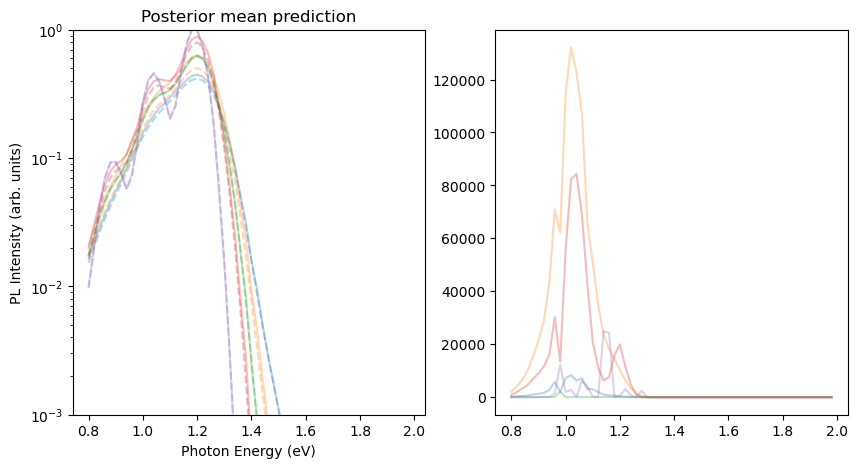

In [136]:
fig, ax = plt.subplots(1,2, figsize=(10, 5))
diff = ((data - model_data)/sigma) ** 2
sigma= sigma+0.001
for i in range(len(temperature_list)):
    ax[0].plot(
        hws,
        model_data[:, i],
        label="true" + str(temperature_list[i]) + " K",
        linestyle="--",
        color="C" + str(i),
        alpha=0.3,
    )
    ax[0].plot(
        hws,
        data[:, i],
        label="true" + str(temperature_list[i]) + " K",
        linestyle="-",
        color="C" + str(i),
        alpha=0.3,
    )
    ax[1].plot(
        hws,
        diff[:, i],
        label="true" + str(temperature_list[i]) + " K",
        linestyle="-",
        color="C" + str(i),
        alpha=0.3,
    )

ax[0].set_xlabel("Photon Energy (eV)")
ax[0].set_ylabel("PL Intensity (arb. units)")
ax[0].set_title("Posterior mean prediction")
ax[0].set_yscale('log')
ax[0].set_ylim([1e-3, 1])